# **Amazon Lookout for Equipment** - Demonstration on an anonymized expander dataset
*Part 5: Scheduling regular inference calls*

In [1]:
BUCKET = 'l4e-lookout-equipment-demo2'
PREFIX = 'data4/scheduled_inference'

### Notebook configuration update
Amazon Lookout for Equipment being a very recent service, we need to make sure that we have access to the latest version of the AWS Python packages. If you see a `pip` dependency error, check that the `boto3` version is ok: if it's greater than 1.17.48 (the first version that includes the `lookoutequipment` API), you can discard this error and move forward with the next cell:

In [2]:
import boto3

### Imports

In [3]:
import boto3
import datetime
import os
import pandas as pd
import pprint
import pyarrow as pa
import pyarrow.parquet as pq
import sagemaker
import s3fs
import sys
import time
import uuid
import warnings

# Helper functions for managing Lookout for Equipment API calls:
sys.path.append('../utils')
import lookout_equipment_utils as lookout

### Parameters

In [4]:
warnings.filterwarnings('ignore')

DATA       = os.path.join('..', 'data')
RAW_DATA   = os.path.join('..', 'dataset')
INFER_DATA = os.path.join(DATA, 'inference')

os.makedirs(os.path.join(INFER_DATA, 'input'), exist_ok=True)
os.makedirs(os.path.join(INFER_DATA, 'output'), exist_ok=True)

ROLE_ARN = "arn:aws:iam::831520308310:role/l4e-role"
REGION_NAME = boto3.session.Session().region_name

## Create an inference scheduler
---
While navigating to the model details part of the console, you will see that you have no inference scheduled yet:

![Schedule Starting point](../assets/schedule_start.png)

### Scheduler configuration
Let's create a new inference schedule: some parameters are mandatory, while others offer some added flexibility.

#### Parameters

* Set `DATA_UPLOAD_FREQUENCY` at which the data will be uploaded for inference. Allowed values are `PT5M`, `PT10M`, `PT15M`, `PT30M` and `PT1H`.
  * This is both the frequency of the inference scheduler and how often data are uploaded to the source bucket.
  *  **Note**: ***the upload frequency must be compatible with the sampling rate selected at training time.*** *For example, if a model was trained with a 30 minutes resampling, asking for 5 minutes won't work and you need to select either PT30M and PT1H for this parameter at inference time.*
* Set `INFERENCE_DATA_SOURCE_BUCKET` to the S3 bucket of your inference data
* Set `INFERENCE_DATA_SOURCE_PREFIX` to the S3 prefix of your inference data
* Set `INFERENCE_DATA_OUTPUT_BUCKET` to the S3 bucket where you want inference results
* Set `INFERENCE_DATA_OUTPUT_PREFIX` to the S3 prefix where you want inference results
* Set `ROLE_ARN_FOR_INFERENCE` to the role to be used to **read** data to infer on and **write** inference output

In [5]:
# Name of the model on which you want to create this inference scheduler
MODEL_NAME_FOR_CREATING_INFERENCE_SCHEDULER = 'lookout-demo-model-v1'

# Name of the inference scheduler you want to create
INFERENCE_SCHEDULER_NAME = f'{MODEL_NAME_FOR_CREATING_INFERENCE_SCHEDULER}-scheduler'

# Mandatory parameters:
INFERENCE_DATA_SOURCE_BUCKET = BUCKET
INFERENCE_DATA_SOURCE_PREFIX = f'{PREFIX}/input/'
INFERENCE_DATA_OUTPUT_BUCKET = BUCKET
INFERENCE_DATA_OUTPUT_PREFIX = f'{PREFIX}/output/'
ROLE_ARN_FOR_INFERENCE = ROLE_ARN
DATA_UPLOAD_FREQUENCY = 'PT5M'

#### Optional parameters

* Set `DATA_DELAY_OFFSET_IN_MINUTES` to the number of minutes you expect the data to be delayed to upload. It's a time buffer to upload data.
* Set ``INPUT_TIMEZONE_OFFSET``. The allow values are : +00:00, +00:30, -01:00, ... +11:30, +12:00, -00:00, -00:30, -01:00, ... -11:30, -12:00
* Set `TIMESTAMP_FORMAT`. The allowed values `EPOCH`, `yyyy-MM-dd-HH-mm-ss` or `yyyyMMddHHmmss`. This is the format of timestamp which is the suffix of the input data file name. This is used by Lookout Equipment to understand which files to run inference on (so that you don't need to remove previous files to let the scheduler finds which one to run on).
* Set `COMPONENT_TIMESTAMP_DELIMITER`. The allowed values `-`, `_` or ` `. This is the delimiter character that is used to separate the component from the timestamp in the input filename.

In [6]:
DATA_DELAY_OFFSET_IN_MINUTES = None
INPUT_TIMEZONE_OFFSET = '+00:00'
COMPONENT_TIMESTAMP_DELIMITER = '_'
TIMESTAMP_FORMAT = 'yyyyMMddHHmmss'

### Create the inference scheduler
The CreateInferenceScheduler API creates a scheduler **and** starts it: this means that this starts costing you right away. However, you can stop and start an existing scheduler at will (see at the end of this notebook):

In [7]:
scheduler = lookout.LookoutEquipmentScheduler(
    scheduler_name=INFERENCE_SCHEDULER_NAME,
    model_name=MODEL_NAME_FOR_CREATING_INFERENCE_SCHEDULER,
    region_name=REGION_NAME
)

scheduler_params = {
    'input_bucket': INFERENCE_DATA_SOURCE_BUCKET,
    'input_prefix': INFERENCE_DATA_SOURCE_PREFIX,
    'output_bucket': INFERENCE_DATA_OUTPUT_BUCKET,
    'output_prefix': INFERENCE_DATA_OUTPUT_PREFIX,
    'role_arn': ROLE_ARN_FOR_INFERENCE,
    'upload_frequency': DATA_UPLOAD_FREQUENCY,
    'delay_offset': DATA_DELAY_OFFSET_IN_MINUTES,
    'timezone_offset': INPUT_TIMEZONE_OFFSET,
    'component_delimiter': COMPONENT_TIMESTAMP_DELIMITER,
    'timestamp_format': TIMESTAMP_FORMAT
}

scheduler.set_parameters(**scheduler_params)

## Prepare the inference data
---
Let's prepare and send some data in the S3 input location our scheduler will monitor:

In [8]:
# Let's load all our original signals:
all_tags_fname = os.path.join(DATA, 'training-data', 'expander.parquet')
table = pq.read_table(all_tags_fname)
all_tags_df = table.to_pandas()
del table
all_tags_df.head()

,signal-001,signal-002,signal-003,signal-004,signal-005,signal-006,signal-007,signal-008,signal-009,signal-010,...,signal-113,signal-114,signal-115,signal-116,signal-117,signal-118,signal-119,signal-120,signal-121,signal-122
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.392371,0.545005,0.296774,0.413289,0.170744,0.482980,0.222063,0.268691,0.749860,0.475116,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345
2015-01-01 00:01:00,0.389415,0.569155,0.290645,0.415646,0.142368,0.532297,0.222063,0.290804,0.776781,0.486884,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.779412,0.810345
2015-01-01 00:02:00,0.378179,0.547750,0.290645,0.406456,0.160959,0.470115,0.235673,0.277115,0.782389,0.472665,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345
2015-01-01 00:03:00,0.381135,0.547750,0.284516,0.401744,0.170744,0.498794,0.249284,0.270446,0.771733,0.484432,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345
2015-01-01 00:04:00,0.381135,0.553238,0.284516,0.406456,0.142368,0.493433,0.194842,0.272025,0.749860,0.484432,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345


Let's load the tags description: this dataset comes with a tag description file including:

* `Tag`: the tag name as it is recorded by the customer in his historian system (for instance the [Honeywell process history database](https://www.honeywellprocess.com/en-US/explore/products/advanced-applications/uniformance/Pages/uniformance-phd.aspx))
* `UOM`: the unit of measure for the recorded signal
* `Subsystem`: an ID linked to the part of the asset this sensor is attached to

From there, we can collect the list of components (subsystem column):

In [9]:
tags_description_fname = os.path.join(RAW_DATA, 'tags_description.csv')
tags_description_df = pd.read_csv(tags_description_fname)
components = tags_description_df['Subsystem'].unique()
tags_description_df.head()

,Tag,UOM,Subsystem
0,signal-001,micra pp,subsystem-05
1,signal-002,micra pp,subsystem-05
2,signal-003,micra pp,subsystem-05
3,signal-004,micra pp,subsystem-05
4,signal-005,micra pp,subsystem-08


To build our sample inference dataset, we will extract a sample from the original evaluation period of the time series where we know something odd is happening (around **November 21st, 2015 at 4am**):

In [10]:
# How many sequences do we want to extract:
num_sequences = 3

# The scheduling frequency in minutes: this **MUST** match the
# resampling rate used to train the model:
frequency = 5

# Loops through each sequence:
start = pd.to_datetime('2015-11-21 04:00:00')
for i in range(num_sequences):
    end = start + datetime.timedelta(minutes=+frequency - 1)
    
    # Rounding time to the previous 5 minutes:
    tm = datetime.datetime.now()
    tm = tm - datetime.timedelta(
        minutes=tm.minute % frequency,
        seconds=tm.second,
        microseconds=tm.microsecond
    )
    tm = tm + datetime.timedelta(minutes=+frequency * (i))
    current_timestamp = (tm).strftime(format='%Y%m%d%H%M%S')

    # For each sequence, we need to loop through all components:
    print(f'Extracting data from {start} to {end}')
    new_index = None
    for component in components:
        # Extracting the dataframe for this component and this particular time range:
        signals = list(tags_description_df.loc[(tags_description_df['Subsystem'] == component), 'Tag'])
        signals_df = all_tags_df.loc[start:end, signals]
        
        # We need to reset the index to match the time 
        # at which the scheduler will run inference:
        if new_index is None:
            new_index = pd.date_range(
                start=tm,
                periods=signals_df.shape[0], 
                freq='1min'
            )
        signals_df.index = new_index
        signals_df.index.name = 'Timestamp'
        signals_df = signals_df.reset_index()

        # Export this file in CSV format:
        component_fname = os.path.join(INFER_DATA, 'input', f'{component}_{current_timestamp}.csv')
        signals_df.to_csv(component_fname, index=None)
    
    start = start + datetime.timedelta(minutes=+frequency)
    
# Upload the whole folder to S3, in the input location:
INFERENCE_INPUT = os.path.join(INFER_DATA, 'input')
!aws s3 cp --recursive --quiet $INFERENCE_INPUT s3://$BUCKET/$PREFIX/input

Extracting data from 2015-11-21 04:00:00 to 2015-11-21 04:04:00
Extracting data from 2015-11-21 04:05:00 to 2015-11-21 04:09:00
Extracting data from 2015-11-21 04:10:00 to 2015-11-21 04:14:00


In [12]:
# Now that we've prepared the data, create the scheduler by running:
create_scheduler_response = scheduler.create()

ConflictException: An error occurred (ConflictException) when calling the CreateInferenceScheduler operation: The requested resource name is already used by existing resource.

Our scheduler is now running and its inference history is currently empty:

![Scheduler created](../assets/schedule_created.png)

## Get inference results
---

### List inference executions

**Let's now wait for 5-15 minutes to give some time to the scheduler to run its first inferences.** Once the wait is over, we can use the ListInferenceExecution API for our current inference scheduler. The only mandatory parameter is the scheduler name.

You can also choose a time period for which you want to query inference executions for. If you don't specify it, then all executions for an inference scheduler will be listed. If you want to specify the time range, you can do this:

```python
START_TIME_FOR_INFERENCE_EXECUTIONS = datetime.datetime(2010,1,3,0,0,0)
END_TIME_FOR_INFERENCE_EXECUTIONS = datetime.datetime(2010,1,5,0,0,0)
```

Which means the executions after `2010-01-03 00:00:00` and before `2010-01-05 00:00:00` will be listed.

You can also choose to query for executions in particular status, the allowed status are `IN_PROGRESS`, `SUCCESS` and `FAILED`.

In [13]:
START_TIME_FOR_INFERENCE_EXECUTIONS = None
END_TIME_FOR_INFERENCE_EXECUTIONS = None
EXECUTION_STATUS = None

execution_summaries = []

while len(execution_summaries) == 0:
    execution_summaries = scheduler.list_inference_executions(
        start_time=START_TIME_FOR_INFERENCE_EXECUTIONS,
        end_time=END_TIME_FOR_INFERENCE_EXECUTIONS,
        execution_status=EXECUTION_STATUS
    )
    if len(execution_summaries) == 0:
        print('WAITING FOR THE FIRST INFERENCE EXECUTION')
        time.sleep(60)
        
    else:
        print('FIRST INFERENCE EXECUTED\n')
        break
            
execution_summaries

WAITING FOR THE FIRST INFERENCE EXECUTION
WAITING FOR THE FIRST INFERENCE EXECUTION
WAITING FOR THE FIRST INFERENCE EXECUTION
WAITING FOR THE FIRST INFERENCE EXECUTION
FIRST INFERENCE EXECUTED



[{'ModelName': 'lookout-demo-model-v1',
  'ModelArn': 'arn:aws:lookoutequipment:eu-west-1:831520308310:model/lookout-demo-model-v1/2fbe82e9-f7fe-45d1-9b66-622382bd1eda',
  'InferenceSchedulerName': 'lookout-demo-model-v1-scheduler',
  'InferenceSchedulerArn': 'arn:aws:lookoutequipment:eu-west-1:831520308310:inference-scheduler/lookout-demo-model-v1-scheduler/bc2ea665-0c59-4332-b2ce-fa994e6bf909',
  'ScheduledStartTime': datetime.datetime(2021, 6, 18, 10, 0, tzinfo=tzlocal()),
  'DataStartTime': datetime.datetime(2021, 6, 18, 9, 55, tzinfo=tzlocal()),
  'DataEndTime': datetime.datetime(2021, 6, 18, 10, 0, tzinfo=tzlocal()),
  'DataInputConfiguration': {'S3InputConfiguration': {'Bucket': 'l4e-lookout-equipment-demo2',
    'Prefix': 'data4/scheduled_inference/input/'}},
  'DataOutputConfiguration': {'S3OutputConfiguration': {'Bucket': 'l4e-lookout-equipment-demo2',
    'Prefix': 'data4/scheduled_inference/output/'}},
  'Status': 'FAILED',
  'FailedReason': 'Could not find data file for se

We have configured this scheduler to run every five minutes. After a few minutes we can also see the history in the console populated with its first executions: if you leave the scheduler to run beyond 15 minutes, any execution after the 3rd one will fail as we only generated 3 sequences above.

![Inference history](../assets/schedule_inference_history.png)

When the scheduler starts (for example `datetime.datetime(2021, 1, 27, 9, 15)`, it looks for **a single** CSV file located in the input location with a filename that contains a timestamp set to the previous step. For example, a file named:

* subsystem-01_2021012709**10**00.csv will be found and ingested
* subsystem-01_2021012708**15**00.csv will **not be** ingested (it will be ingested at the next inference execution)

In addition, when opening the file `subsystem-01_20210127091000.csv`, it will look for any row with a date that is between the DataStartTime and the DataEndTime of the inference execution. **If it doesn't find such a row, an internal exception will be thrown.**

### Download inference results
Let's have a look at the content now available in the scheduler output location: each inference execution creates a subfolder in the output directory. The subfolder name is the timestamp (GMT) at which the inference was executed and it contains a single [JSON lines](https://jsonlines.org/) file named `results.jsonl`:

![Inference input](../assets/schedule_inference_output_data.png)

Each execution summary is a JSON document that has the following format:

In [14]:
execution_summaries[0]

{'ModelName': 'lookout-demo-model-v1',
 'ModelArn': 'arn:aws:lookoutequipment:eu-west-1:831520308310:model/lookout-demo-model-v1/2fbe82e9-f7fe-45d1-9b66-622382bd1eda',
 'InferenceSchedulerName': 'lookout-demo-model-v1-scheduler',
 'InferenceSchedulerArn': 'arn:aws:lookoutequipment:eu-west-1:831520308310:inference-scheduler/lookout-demo-model-v1-scheduler/bc2ea665-0c59-4332-b2ce-fa994e6bf909',
 'ScheduledStartTime': datetime.datetime(2021, 6, 18, 10, 0, tzinfo=tzlocal()),
 'DataStartTime': datetime.datetime(2021, 6, 18, 9, 55, tzinfo=tzlocal()),
 'DataEndTime': datetime.datetime(2021, 6, 18, 10, 0, tzinfo=tzlocal()),
 'DataInputConfiguration': {'S3InputConfiguration': {'Bucket': 'l4e-lookout-equipment-demo2',
   'Prefix': 'data4/scheduled_inference/input/'}},
 'DataOutputConfiguration': {'S3OutputConfiguration': {'Bucket': 'l4e-lookout-equipment-demo2',
   'Prefix': 'data4/scheduled_inference/output/'}},
 'Status': 'FAILED',
 'FailedReason': 'Could not find data file for sensor subsyste

When the `Status` key from the previous JSON result is set to `SUCCESS`, you can collect the results location in the `CustomerResultObject` field. We are now going to loop through each execution result and download each JSON lines files generated by the scheduler. Then we will insert their results into an overall dataframe for further analysis:

In [13]:
# Fetch the list of execution summaries in case all executions were not captured yet:
_ = scheduler.list_inference_executions()

# Loops through the executions summaries:
results_json = []
for execution_summary in scheduler.execution_summaries:
    print('.', end='')
    
    # We only get an output if the inference execution is a sucess:
    status = execution_summary['Status']
    if status == 'SUCCESS':
        # Download the JSON-line file locally:
        bucket = execution_summary['CustomerResultObject']['Bucket']
        key = execution_summary['CustomerResultObject']['Key']
        current_timestamp = key.split('/')[-2]
        local_fname = os.path.join(INFER_DATA, 'output', f'centrifugal-pump_{current_timestamp}.jsonl')
        s3_fname = f's3://{bucket}/{key}'
        
        !aws s3 cp --quiet $s3_fname $local_fname
        
        # Opens the file and concatenate the results into a dataframe:
        with open(local_fname, 'r') as f:
            content = [eval(line) for line in f.readlines()]
            results_json = results_json + content
    
# Build the final dataframes with all the results:
results_df = pd.DataFrame(results_json)
results_df['timestamp'] = pd.to_datetime(results_df['timestamp'])
results_df = results_df.set_index('timestamp')
results_df = results_df.sort_index()
results_df.head()

..................

,prediction,diagnostics
timestamp,,
2021-06-18 10:00:00,1,"[{'name': 'subsystem-05\signal-001', 'value': ..."
2021-06-18 10:05:00,1,"[{'name': 'subsystem-05\signal-001', 'value': ..."
2021-06-18 10:10:00,1,"[{'name': 'subsystem-05\signal-001', 'value': ..."


The content of each JSON lines file follows this format:
    
```json
[
    {
        'timestamp': '2021-04-17T13:25:00.000000',
        'prediction': 1,
        'diagnostics': [
            {'name': 'subsystem-19\\signal-067', 'value': 0.12},
            {'name': 'subsystem-18\\signal-099', 'value': 0.0},
            {'name': 'subsystem-09\\signal-016', 'value': 0.0},
                                  .
                                  .
                                  .
            {'name': 'subsystem-06\\signal-119', 'value': 0.08},
            {'name': 'subsystem-10\\signal-071', 'value': 0.02},
            {'name': 'subsystem-20\\signal-076', 'value': 0.02}
        ]
    }
    ...
]
```
Each timestamp found in the file is associated to a prediction: 1 when an anomaly is detected an 0 otherwise. When the `prediction` field is 1 (an anomaly is detected), the `diagnostics` field contains each sensor (with the format `component`\\`tag`) and an associated percentage. This percentage corresponds to the magnitude of impact of a given sensor to the detected anomaly. For instance, in the example above, the tag `signal-067` located on the `subsystem-19` component has an estimated 12% magnitude of impact to the anomaly detected at 8pm on April 7th 2021. This dataset has 122 sensors: if each sensor contributed the same way to this event, the impact of each of them would be `100 / 122 = 0.82%`, so 12% is indeed statistically significant.

### Visualizing the inference results

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

%matplotlib inline
plt.style.use('Solarize_Light2')
plt.rcParams['lines.linewidth'] = 0.5

#### Single inference analysis
Let's first expand the results to expose the content of the **diagnostics** column above into different dataframe columns:

In [15]:
expanded_results = []
for index, row in results_df.iterrows():
    new_row = dict()
    new_row.update({'timestamp': index})
    new_row.update({'prediction': row['prediction']})
    
    if row['prediction'] == 1:
        diagnostics = pd.DataFrame(row['diagnostics'])
        diagnostics = dict(zip(diagnostics['name'], diagnostics['value']))
        new_row = {**new_row, **diagnostics}
        
    expanded_results.append(new_row)
    
expanded_results = pd.DataFrame(expanded_results)
expanded_results['timestamp'] = pd.to_datetime(expanded_results['timestamp'])
expanded_results = expanded_results.set_index('timestamp')
expanded_results.head()

,prediction,subsystem-05\signal-001,subsystem-05\signal-002,subsystem-05\signal-003,subsystem-05\signal-004,subsystem-05\signal-046,subsystem-05\signal-047,subsystem-05\signal-077,subsystem-05\signal-081,subsystem-05\signal-106,...,subsystem-09\signal-104,subsystem-09\signal-105,subsystem-13\signal-080,subsystem-13\signal-091,subsystem-14\signal-094,subsystem-22\signal-097,subsystem-24\signal-083,subsystem-23\signal-098,subsystem-15\signal-089,subsystem-12\signal-065
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-06-18 10:00:00,1,0.0,0.02,0.0,0.0,0.02,0.0,0.02,0.0,0.02,...,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.00,0.0,0.0
2021-06-18 10:05:00,1,0.0,0.02,0.0,0.0,0.02,0.0,0.02,0.0,0.02,...,0.0,0.0,0.0,0.02,0.0,0.00,0.0,0.00,0.0,0.0
2021-06-18 10:10:00,1,0.0,0.02,0.0,0.0,0.02,0.0,0.02,0.0,0.02,...,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.02,0.0,0.0


Each detected event have some detailed diagnostics. Let's unpack the details for the first event and plot a similar bar chart than what the console provides when it evaluates a trained model:

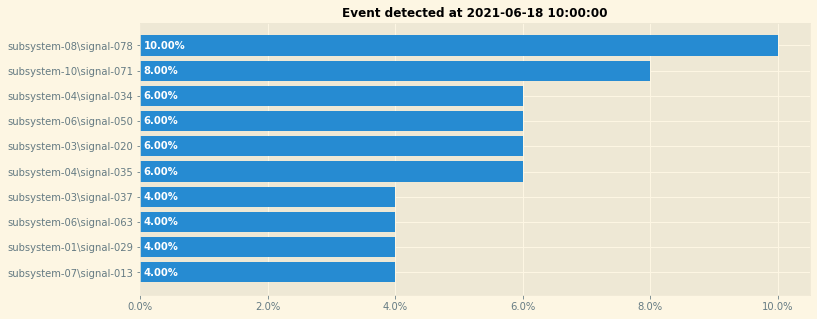

In [16]:
event_details = pd.DataFrame(expanded_results.iloc[0, 1:]).reset_index()
event_details.columns = ['name', 'value']
event_details = event_details.sort_values(by='value')
event_details_limited = event_details.tail(10)

# We can then plot a horizontal bar chart:
y_pos = np.arange(event_details_limited.shape[0])
values = list(event_details_limited['value'])

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(1,1,1)
ax.barh(y_pos, event_details_limited['value'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(event_details_limited['name'])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add the values in each bar:
for i, v in enumerate(values):
    if v == 0:
        ax.text(0.0005, i, f'{v*100:.2f}%', color='#000000', verticalalignment='center')
    else:
        ax.text(0.0005, i, f'{v*100:.2f}%', color='#FFFFFF', fontweight='bold', verticalalignment='center')
    
plt.title(f'Event detected at {expanded_results.index[0]}', fontsize=12, fontweight='bold')
plt.show()

As we did in the previous notebook, the above bar chart is already of great help to pinpoint what might be going wrong with your asset. Let's load the initial tags description file we prepared in the first notebook and match the sensors with our initial components to group sensors by component:

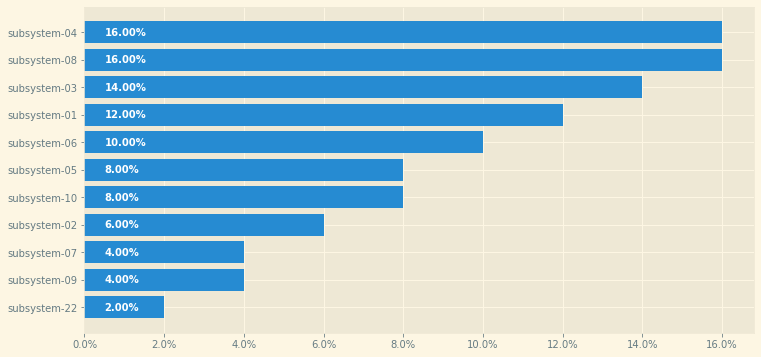

In [17]:
# Agregate event diagnostics at the component level:
event_details[['asset', 'sensor']] = event_details['name'].str.split('\\', expand=True)
component_diagnostics = event_details.groupby(by='asset').sum().sort_values(by='value')
component_diagnostics = component_diagnostics[component_diagnostics['value'] > 0.0]

# Prepare Y position and values for bar chart:
y_pos = np.arange(component_diagnostics.shape[0])
values = list(component_diagnostics['value'])

# Plot the bar chart:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1,1,1)
ax.barh(y_pos, component_diagnostics['value'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(list(component_diagnostics.index))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add the values in each bar:
for i, v in enumerate(values):
    ax.text(0.005, i, f'{v*100:.2f}%', color='#FFFFFF', fontweight='bold', verticalalignment='center')
    
# Show the final plot:
plt.show()

## Inference scheduler operations
---
### Stop inference scheduler
**Be frugal**, running the scheduler is the main cost driver of Amazon Lookout for Equipment. Use the following API to stop an already running inference scheduler. This will stop the periodic inference executions:

In [18]:
scheduler.stop()

===== Polling Inference Scheduler Status =====

Scheduler Status: STOPPING
Scheduler Status: STOPPED

===== End of Polling Inference Scheduler Status =====


### Start an inference scheduler
You can restart any `STOPPED` inference scheduler using this API:

In [19]:
scheduler.start()

===== Polling Inference Scheduler Status =====

Scheduler Status: PENDING
Scheduler Status: RUNNING

===== End of Polling Inference Scheduler Status =====


### Delete an inference scheduler
You can delete a **stopped** scheduler you have no more use of: you can only have one scheduler per model.

In [20]:
scheduler.stop()
scheduler.delete()

===== Polling Inference Scheduler Status =====

Scheduler Status: STOPPING
Scheduler Status: STOPPED

===== End of Polling Inference Scheduler Status =====


{'ResponseMetadata': {'RequestId': '685d8026-84ee-48cf-8146-9a292f685e12',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '685d8026-84ee-48cf-8146-9a292f685e12',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '0',
   'date': 'Fri, 18 Jun 2021 10:16:50 GMT'},
  'RetryAttempts': 0}}

## Conclusion
---
In this notebook, we used the model created in part 3 of this notebook, configured a scheduler and extracted the predictions obtained after it executed a few inferences.